# Phase 3 Project Tanzanian Water Wells

## Binary Logistic regression Model

In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_curve
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

In [98]:
tz_data = pd.read_csv('tz_data.csv')

In [99]:
data = tz_data.copy()
data

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,payment_type,quality_group,quantity_group,source,waterpoint_type_group,status_group
0,69572,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,109,True,VWC,False,1999,gravity,annually,good,enough,spring,communal standpipe,2
1,8776,0.0,other,1399,other,34.698766,-2.147466,Lake Victoria,280,True,Other,True,2010,gravity,never pay,good,insufficient,rainwater harvesting,communal standpipe,2
2,34310,25.0,other,686,other,37.460664,-3.821329,Pangani,250,True,VWC,True,2009,gravity,per bucket,good,enough,dam,communal standpipe,2
3,67743,0.0,other,263,other,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,VWC,True,1986,submersible,never pay,good,dry,machine dbh,communal standpipe,0
4,19728,0.0,other,0,other,31.130847,-1.825359,Lake Victoria,0,True,VWC,True,2000,gravity,never pay,good,seasonal,rainwater harvesting,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,other,1210,other,37.169807,-3.253847,Pangani,125,True,Water Board,True,1999,gravity,per bucket,good,enough,spring,communal standpipe,2
59396,27263,4700.0,other,1212,other,35.249991,-9.070629,Rufiji,56,True,VWC,True,1996,gravity,annually,good,enough,river,communal standpipe,2
59397,37057,0.0,Government Of Tanzania,0,DWE,34.017087,-8.750434,Rufiji,0,True,VWC,False,2000,handpump,monthly,fluoride,enough,machine dbh,hand pump,2
59398,31282,0.0,other,0,other,35.861315,-6.378573,Rufiji,0,True,VWC,True,2000,handpump,never pay,good,insufficient,shallow well,hand pump,2


In [100]:
data = data.drop('id', axis =1)

In [101]:
# Changing all T/F columns 
bool_columns = data.select_dtypes(include=bool).columns
data[bool_columns] = data[bool_columns].astype(int)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   population             59400 non-null  int64  
 8   public_meeting         59400 non-null  int64  
 9   scheme_management      59400 non-null  object 
 10  permit                 59400 non-null  int64  
 11  construction_year      59400 non-null  int64  
 12  extraction_type_class  59400 non-null  object 
 13  payment_type           59400 non-null  object 
 14  quality_group          59400 non-null  object 
 15  qu

# Target
>- 0 = Non-functional
>- 1 = Functional but needs repair
>- 2 =  Functional
>- Assigning new values those that are functional water pums as 1 and nun functioning as zero

In [103]:
target_status = {0: 0, 1: 1, 2 : 1}
data['status_group'] = data['status_group'].replace(target_status)

In [104]:
data['status_group'].value_counts()

status_group
1    36576
0    22824
Name: count, dtype: int64

In [105]:
X = data.drop('status_group', axis=1)  
y = data['status_group']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Processing 
>- setting the columns based on their features for pipeline modeling

In [107]:
cat_cols = ['funder', 'installer', 'basin', 'scheme_management', 'extraction_type_class', 'payment_type', 'quality_group', 
              'quantity_group', 'source', 'waterpoint_type_group']

num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude','population', 'construction_year']
bin_cols = ['permit', 'public_meeting']

In [108]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
    
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures()),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent'))
])
# smote = SMOTENC(categorical_features=cat_cols)

In [109]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols),
        ('bins',binary_transformer, bin_cols)
    ])

In [64]:
# X_preprocessed = preprocessor.fit_transform(X)

# # Apply SMOTENC to the categorical features
# smote = SMOTENC(categorical_features=[X_preprocessed[:, i] for i in range(len(cat_cols))])
# X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

## Logistic Regression

In [110]:
Model = Pipeline(steps=[
    ('processes', CT),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced', random_state =42))
])

In [111]:
Model.fit(X_train, y_train)

Pipeline(steps=[('processes',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['funder', 'installer',
                                                   'basin', 'scheme_management',
                                                   'extraction_type_class',
                                                   'payment_type',
                                                   'quality_group',
                                                   'quantity_group', 'source',
                                                   'waterpoint_type_group']),
                                                 ('num',
                                                  Pipeline(steps=[('im...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population',
                                                   'construction_year']),
                                                 ('bins',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['permit',
                                                   'public_meeting'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=42))])

In [113]:
Model.score(X_train, y_train)

0.78373285089703

In [114]:
Model.score(X_test, y_test)

0.7846648301193756

In [116]:
y_pred = Model.predict(X_test)

In [118]:
y_train_pred = Model.predict(X_train)
y_test_pred = Model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.78373285089703
Test Accuracy: 0.7846648301193756

Balanced Accuracy:
Train Accuracy: 0.7649107919354521
Test Accuracy: 0.764434091783553


              precision    recall  f1-score   support

           0       0.73      0.68      0.71      7458
           1       0.81      0.85      0.83     12144

    accuracy                           0.78     19602
   macro avg       0.77      0.76      0.77     19602
weighted avg       0.78      0.78      0.78     19602



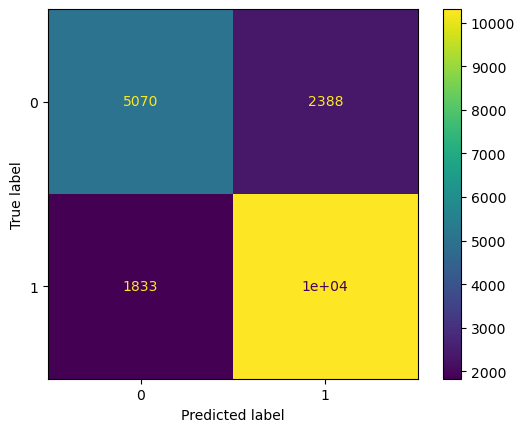

In [128]:
print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [129]:
from sklearn.metrics import log_loss

y_train_pred_proba = Model.predict_proba(X_train)
y_test_pred_proba = Model.predict_proba(X_test)

train_log_loss = log_loss(y_train, y_train_pred_proba)
print("Train Log Loss:", train_log_loss)

test_log_loss = log_loss(y_test, y_test_pred_proba)
print("Test Log Loss:", test_log_loss)

Train Log Loss: 0.4713760287816769
Test Log Loss: 0.47167308675498126


Text(0.5, 0, 'False Positive Rate')

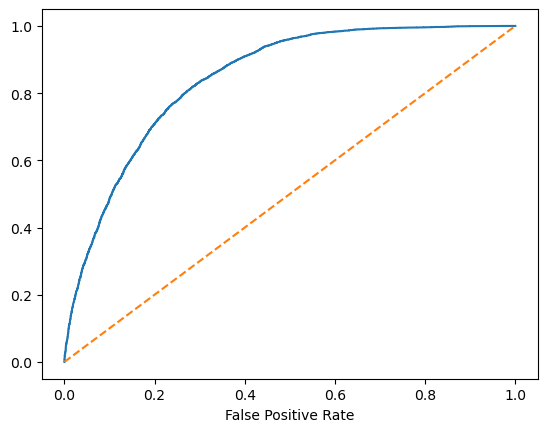

In [131]:
probs = Model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')

In [133]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1'],
    "max_features": ['sqrt', 'log2'],
}

In [355]:
# grid_search = GridSearchCV(pipeline, param_grid, cv= 5, n_jobs=-1, scoring='roc_auc')

In [356]:
# grid_search.fit(X_train, y_train)

In [357]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [134]:
y_pred = best_model.predict(X_test)

NameError: name 'best_model' is not defined

In [135]:
import numpy as np

unique_values = np.unique(y_train)
print(unique_values)

[0 1]


In [136]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7846648301193756

In [137]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("Accuracy:")
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

NameError: name 'best_model' is not defined

In [138]:
data_results = pd.DataFrame(columns=["Model", "test_acc",
                                   'train_acc', 'info', 'param'])

In [139]:
results_1 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_acc": [0.5], 
       'train__acc' : [0.5],
               'info' : ['DummyModel']
})
data_results = pd.concat([data_results, results_1], ignore_index =True)

In [140]:
results_2 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_acc": [0.738], 
       'train_acc' : [0.737],
               'info' : ['fsm_pipeline'],
})
data_results = pd.concat([data_results, results_2], ignore_index =True)

In [141]:
results_3 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_acc": [0.764], 
       'train__acc' : [0.764],
               'info' : ['with funder'],
})
data_results = pd.concat([data_results, results_3], ignore_index =True)

In [ ]:
results_4 = pd.DataFrame({       
     "Model": ['LogisticRegression'],
      "test_balanced_acc": [0.511], 
       'train_balanced_acc' : [0.510],
               'info' : ['fsm'],
})
data_results = pd.concat([data_results, results_4], ignore_index =True)

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
data_results

              precision    recall  f1-score   support

           0       0.73      0.68      0.71      7458
           1       0.81      0.85      0.83     12144

    accuracy                           0.78     19602
   macro avg       0.77      0.76      0.77     19602
weighted avg       0.78      0.78      0.78     19602



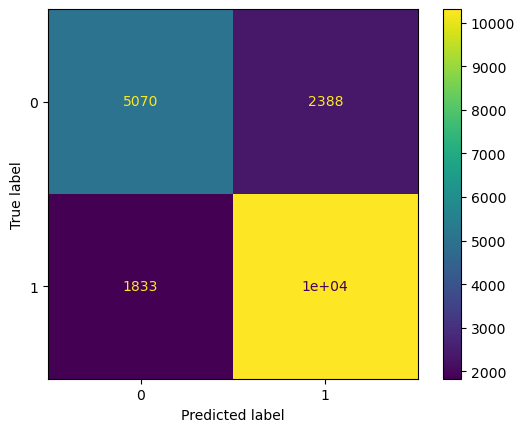

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Logistic regression With SMOTE
>- model performed well on training and the test, but the balanced accuracy is much lower meaning there's huge class imbalance
>- Below is the model with SMOTE

In [ ]:
# class SMOTETransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, **kwargs):
#         self.kwargs = kwargs

#     def fit(self, X, y):
#         self.smote = SMOTE(**self.kwargs)
#         return self

#     def transform(self, X, y=None):
#         return self.smote.fit_resample(X, y)

In [ ]:
# smote_transformer = SMOTETransformer(sampling_strategy=0.5, k_neighbors=5)
# X_train_resampled, y_train_resampled = smote_transformer.fit_transform(X_train_sm, y_train_sm)